In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
import math, os, time, sys

sys.path.append(os.getcwd())
from func import *
import random



regr_RF = RandomForestRegressor(n_estimators = 10, max_features=1, random_state=42)
lasso = LassoCV(cv=5, fit_intercept=False, random_state=1) #, max_iter = 10000)

# 1. Get leaf pixels through thresholding

In [ ]:
# dir_list: all directory under the path
path='H:\\soybean\\'
dir_list = [directory for directory in os.listdir(path) if os.path.isdir(path+directory)]
dir_list[0]

"""
experiment id:716
plant id:573
date (yy-mm-dd): 2019-07-30
time (hh-mm-ss.sss): 22-19-40.753
"""

# ground truth data
g_truth = pd.read_excel(r"\NIC soybean 2019.xlsx").dropna()
g_truth['Plant ID']=g_truth['Plant ID'].apply(lambda x : x%1000)
#g_truth.set_index('Plant ID', inplace = True)
g_truth.tail()

## 1.1 Get pixels from the last day image before destructive sampling of destructed plants for calibration

In [ ]:
# get year and plant id starting index
year='2019'
date_index=dir_list[0].find(year)
p_id='573'
id_index=dir_list[1].find(p_id)
time='22-19'
time_index=dir_list[0].find(time)

# get date and plant id list
dates=[date[date_index: date_index+16] for date in dir_list]
#dates=[date[date_index: date_index+10] for date in dir_list]
plant_ids=[plant_id[id_index: id_index+3] for plant_id in dir_list]
#times=[time[time_index: time_index+5] for time in dir_list]

In [ ]:
dir_list_last_day=[]
for i in range(1, len(plant_ids)):
    
    if plant_ids[i]!=plant_ids[i-1]:
        dir_list_last_day.append(dir_list[i-1])
    if plant_ids[i]=='639':
        break
#dir_list_last_day

# get date and plant id list
dates_last_day=[date[date_index: date_index+16] for date in dir_list_last_day]
#dates=[date[date_index: date_index+10] for date in dir_list]
plant_ids_last_day=[plant_id[id_index: id_index+3] for plant_id in dir_list_last_day]
#times=[time[time_index: time_index+5] for time in dir_list]

In [ ]:
# the first folder contains no plant
destruct_df1 = pd.DataFrame()
#ind= plant_ids_last_day.index('63')
destruct_df1['Plant ID']= plant_ids_last_day[1: ]
destruct_df1['Directory'] =dir_list_last_day[1: ]
destruct_df1['Last_Image_Date'] =dates_last_day[1: ]
destruct_df1.head()


In [ ]:



camera_dic={'Vis_SV_0':[], 'Vis_SV_36': [], 'Vis_SV_72': [], 'Vis_SV_108': [], 'Vis_SV_144': [], 
              'Vis_SV_216': [], 'Vis_SV_252':[], 'Vis_SV_288':[], 'Vis_SV_324':[], 'Vis_TV_90': [] }


y = g_truth['Leaf Area (cm^2)']
result = {'threshold': [], 'R2':[]}
threshold = np.arange(1.04, 1.16, 0.01)
path='H:\\soybean\\'   

for thre in threshold:

    print(thre)
    
  
    threshold, X, df = get_pixel_from_sub_directory(path, destruct_df1['Directory'], camera_dic, thre, 
                                                    save_image= False
                                 save_file= False, is_concat = True, df1 = destruct_df1)

    thre_df=pd.DataFrame.from_dict(threshold)
    df= pd.concat([thre_df, df], axis=1)
    
    df['Plant ID'] = df['Plant ID'].astype(int)
    final_df = pd.merge(df, g_truth, on=['Plant ID'])

    final_df.to_csv(path+ 'soybean_destruct_one_thre_' + str(thre) + '.csv', index=False)
    
    #final_df = pd.read_csv(path+ 'soybean_destruct_one_thre_' + str(thre) + '.csv')
  

#2. Implementation of the ADMM based algorithm to select the threshold c for plant segmentation

## 2.1 ADMM

Select the threshold and beta combination

Some of the msve plot don't have U shape, because regular lasso have produce negative beta if given smaller alpha, and the msve changes with alpha. But restricted admm keep the negative to zero and others relatively nonchanged even we make alpha smaller, so the msve converges.

34
1.04
alpha 8672364.44116227
coefficient [ 0.          0.          0.00036597  0.          0.00390443  0.
  0.         -0.         -0.          0.00264424]
lasso score 0.906694556913889
RF score 0.9542793737571755
prediction r2 0.8854927906622735


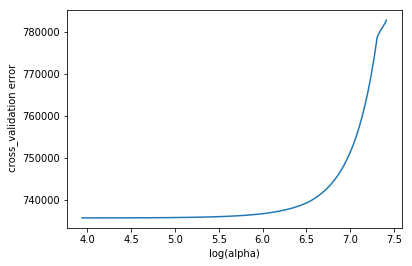

1.05
alpha 7561647.0985087715
coefficient [ 0.         0.0021474  0.0016024  0.         0.0031115  0.
  0.        -0.        -0.         0.       ]
lasso score 0.9708974035648772
RF score 0.962876888413848
prediction r2 0.9704705615729032


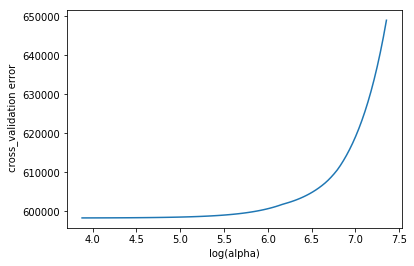

1.06
alpha 7467780.417595269
coefficient [ 0.          0.00269624  0.00135008  0.          0.00293979  0.
  0.          0.         -0.          0.        ]
lasso score 0.9736242752177308
RF score 0.9634369672403006
prediction r2 0.9727952487556583


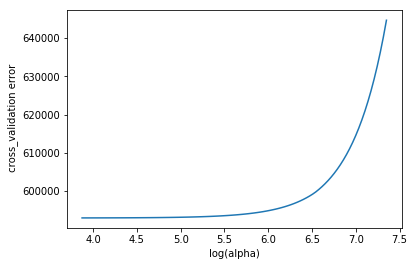

1.07
alpha 6899801.639359417
coefficient [ 0.          0.00296421  0.0011644   0.          0.00293666  0.
  0.         -0.         -0.          0.        ]
lasso score 0.9746629709422757
RF score 0.9685822044431464
prediction r2 0.9739664355389578


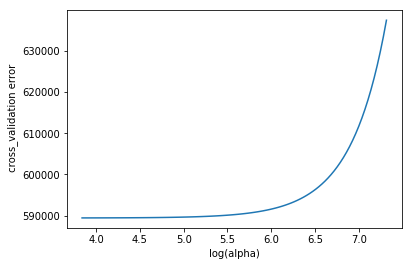

1.08
alpha 6829251.181011432
coefficient [ 0.          0.00322529  0.0009441   0.          0.00297709  0.
  0.         -0.         -0.          0.        ]
lasso score 0.975270632984006
RF score 0.9704942880294543
prediction r2 0.9746700711185977


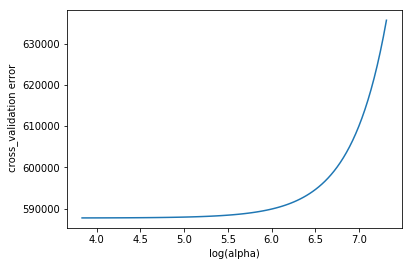

1.09
alpha 6752586.071155076
coefficient [ 0.          0.00343174  0.00081811  0.          0.00299211  0.
  0.         -0.         -0.          0.        ]
lasso score 0.9752785072212378
RF score 0.9618418028756905
prediction r2 0.9748059615299209


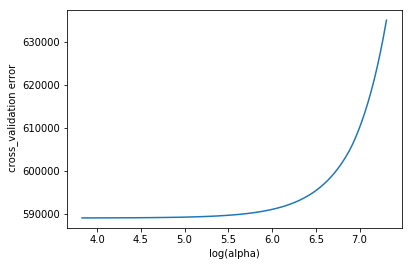

1.1
alpha 6655513.264121494
coefficient [ 0.          0.00372054  0.00064037  0.          0.00300452  0.
  0.         -0.         -0.          0.        ]
lasso score 0.9741940573580666
RF score 0.9544282668551768
prediction r2 0.973843026506968


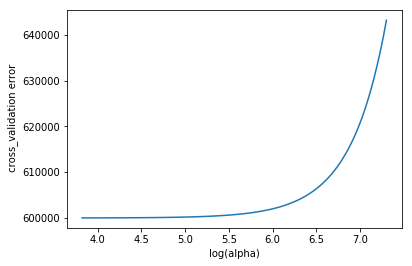

1.11
alpha 6555423.586275644
coefficient [ 0.          0.00406091  0.00040874  0.          0.00302254  0.
  0.         -0.         -0.          0.        ]
lasso score 0.9723614091064148
RF score 0.9387562890220789
prediction r2 0.9720856307316394


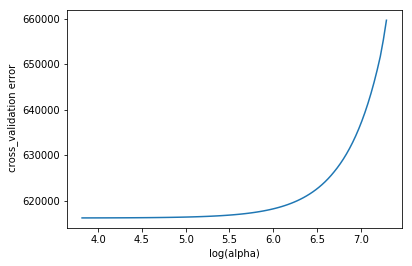

1.12
alpha 6889029.095298096
coefficient [ 0.00000000e+00  4.55552258e-03  3.68784815e-05  0.00000000e+00
  3.06114926e-03  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
lasso score 0.9677849424699402
RF score 0.9308968015594258
prediction r2 0.9676118353701526


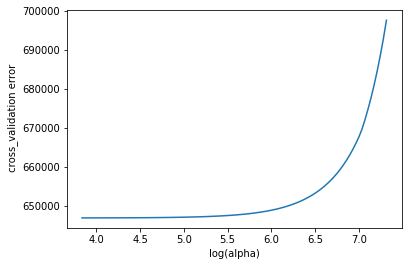



34
[(587733.7301648126, 1.08), (589055.6840314458, 1.09), (589415.3505733281, 1.07), (593008.6192621875, 1.06), (598354.1204078344, 1.05), (599931.1290009838, 1.1), (616204.2339817546, 1.11), (646822.8964563556, 1.12), (735717.3021512323, 1.04)]


[(587733.7301648126, 1.08)]


In [124]:


msve = {}
min_index={}
admm_alph={}
pred_r2={}

#random.seed(1)
#rand = [random.randint(0, 100) for i in range(50)]
seq= 0.01
min_min_msve=[]


seed = 3
for thre in np.arange(1.04, 1.12, seq):
    print(thre)
    msve[thre] = []
    min_index[thre]=[]
    admm_alph[thre]=[]
    pred_r2[thre]=[]

    # read the thresholded pixel count from multivew images
    df = pd.read_csv(r'soybean_destruct_one_thre_'
                                        +str(thre) +'.csv')
  
    df = df[df['Group']== 'early'].sort_values(['Last_Image_Date'])
    lasso = LassoCV(cv=5, random_state=seed, fit_intercept = False, max_iter = 100000)
    
    test_df = df.groupby('Image_Date', group_keys = False).apply(pd.DataFrame.sample, frac= 0.3, 
                                                                    replace = False, random_state= seed)
    train_df = df.loc[~df.index.isin(test_df.index)]

    X_test = test_df.loc[:, 'Vis_SV_0': 'Vis_TV_90'] 
    X_train = train_df.loc[:, 'Vis_SV_0': 'Vis_TV_90'] 
    y_test = test_df['Leaf Area (cm^2)']
    y_train = train_df['Leaf Area (cm^2)']

    # getting the penalty parameter lambda initial grid from regular lasso regression without restriction
    lasso.fit(X_train, y_train)
    print('alpha', lasso.alpha_)
    print('coefficient', lasso.coef_)
    print('lasso score', lasso.score(X_test, y_test))
    regr_RF.fit(X_train, y_train)
    print('RF score', regr_RF.score(X_test, y_test))
    optm_alpha = lasso.alpha_

    grid = 10**np.linspace(np.log10(optm_alpha/1000), np.log10(optm_alpha*3), 100)     

    # save the mean square validation error vectors (because of lambda grid) for different threshold c
    n_iter=1000
    msve_ = msve_comparison(X_train, y_train, X_test, y_test, grid, n_iter )
    
    msve[thre].append(msve_)

    # find the min msve for each threshold
    min_index[thre].append(msve_.index(min(msve_)))
    admm_alph[thre].append(grid[min_index[thre][-1]])

    # output the predicted r2
    X_train_np = X_train.to_numpy(copy=True)
    y_train_np = y_train.to_numpy(copy=True).reshape(-1, 1)
    n = X_train.shape[0]
    p = X_train.shape[1]
    beta_t = admm_solver(X_train_np, y_train_np, p, lamb= n*admm_alph[thre][-1] , max_iter=n_iter)
    y_pred = X_test.dot(beta_t[-1])
    print('prediction r2', r2_score(y_test, y_pred))
    pred_r2[thre].append(r2_score(y_test, y_pred))
    
    # plot the msve on lambda grid
    #print('beta', beta_t[-1])
    log_alphas = np.log10(grid)

    sns.lineplot(x=log_alphas, y=msve[thre][0])
    
    plt.xlabel('log(alpha)')
    plt.ylabel(' cross_validation error') 
    plt.show()

print('\n')
print(seed)
min_msve=[]

# array to store the min msve for each threshold
for thre in np.arange(1.04, 1.12, seq):
    min_msve.append((np.min(msve[thre]), thre))
min_msve.sort()
print(min_msve)
print('\n')

# the minimun of min msve across threshold
min_min_msve.append(min_msve[0])
print(min_min_msve)
        


In [125]:
min_msve=[]
for thre in np.arange(1.04, 1.12, seq):
    min_msve.append((np.min(msve[thre]), thre))
min_msve.sort()
print(min_msve)
print('\n')
print(pred_r2)
print(beta_t[-1])

[(587733.7301648126, 1.08), (589055.6840314458, 1.09), (589415.3505733281, 1.07), (593008.6192621875, 1.06), (598354.1204078344, 1.05), (599931.1290009838, 1.1), (616204.2339817546, 1.11), (646822.8964563556, 1.12), (735717.3021512323, 1.04)]


{1.04: [0.8854927906622735], 1.05: [0.9704705615729032], 1.06: [0.9727952487556583], 1.07: [0.9739664355389578], 1.08: [0.9746700711185977], 1.09: [0.9748059615299209], 1.1: [0.973843026506968], 1.11: [0.9720856307316394], 1.12: [0.9676118353701526]}
[[-3.69310138e-12]
 [ 4.57962236e-03]
 [ 2.44385359e-04]
 [ 1.19166066e-11]
 [ 2.87909436e-03]
 [-4.53106302e-12]
 [ 1.42906242e-11]
 [ 2.52325105e-11]
 [ 1.30606637e-11]
 [ 2.02016182e-12]]


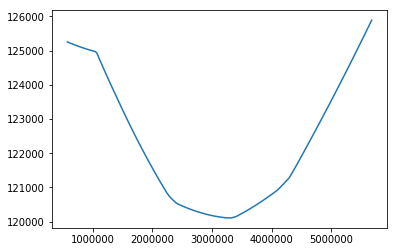

In [714]:
sns.lineplot(x=grid, y=msve[1.08][0])

# 3. obtain leaf pixels of all plants at all time points using the selected threshold c

In [ ]:
# get date and plant id list
dates=[date[date_index: date_index+16] for date in dir_list]
#dates=[date[date_index: date_index+10] for date in dir_list]
plant_ids=[plant_id[id_index: id_index+3] for plant_id in dir_list]
#times=[time[time_index: time_index+5] for time in dir_list]

# the first folder contains no plant
all_df1 = pd.DataFrame()
# data after 665 are missing
ind= plant_ids.index('666')
all_df1['Plant ID']= plant_ids[1: ind]
all_df1['Directory'] =dir_list[1: ind]
all_df1['Image_Date'] =dates[1: ind]
all_df1.tail()
print(len(all_df1))

In [ ]:

threshold = [1.08]
path='H:\\soybean\\'   

for thre in threshold:

    print(thre)
    
    camera_dic={'Vis_SV_0':[], 'Vis_SV_36': [], 'Vis_SV_72': [], 'Vis_SV_108': [], 'Vis_SV_144': [], 
              'Vis_SV_216': [], 'Vis_SV_252':[], 'Vis_SV_288':[], 'Vis_SV_324':[], 'Vis_TV_90': [] }
    
    threshold, X, df = get_pixel_from_sub_directory(path, all_df1['Directory'], camera_dic, thre, 
                                                    save_image= False
                                 save_file= False, is_concat = True, df1 = all_df1)

    thre_df=pd.DataFrame.from_dict(threshold)
    df= pd.concat([thre_df, df], axis=1)
    
    df['Plant ID'] = df['Plant ID'].astype(int)
    

    df.to_csv(path+ 'soybean_all_one_thre' + str(thre) + '.csv', index=False)
    
    df = pd.read_csv(path+ 'soybean_all_one_thre' + str(thre) + '.csv')
    
  